# Locking Actions

This example demonstrates the use of various locking-related actions. 

## The FINESSE Model

Defining a simple interferometer


In [1]:
import finesse
from finesse.analysis.actions import GetErrorSignals, CheckLinearity, RunLocks, DragLocks
from finesse.analysis.actions import SensingMatrixDC, OptimiseRFReadoutPhaseDC
from finesse.analysis.actions.locks import SetLockGains
finesse.configure(plotting=True)

kat = finesse.Model()
kat.parse(
    """
    # Adding a laser and modulator for use in
    # Pound-Drever-Hall-like signals.
    l L0 P=1
    s l_mod1 L0.p1 eo1.p1
    mod eo1 10M 0.1

    s s0 eo1.p2 BS.p1
    bs BS R=0.5 T=0.5

    # North Arm
    s s1 BS.p2 NI.p1
    m NI R=0.99 T=0.01 Rc=1429 phi=90
    s CAV NI.p2 NE.p1 L=10
    m NE R=0.991 T=0.009 Rc=1430 phi=90

    #East Arm
    s s2 BS.p3 EI.p1
    m EI R=0.99 T=0.01 Rc=1429 phi=0
    s CAV2 EI.p2 EE.p1 L=10
    m EE R=0.991 T=0.009 Rc=1430 phi=0

    dof NEz NE.dofs.z +1
    dof EEz EE.dofs.z +1
    dof NIz NI.dofs.z +1

    readout_rf rd_pdh1 NI.p1.o f=10M
    readout_rf rd_pdh2 EI.p1.o f=10M
    readout_rf rd_DF BS.p4.o f=10M

    # Two locks to put the cavities in resonance, and
    # one to move to the dark fringe.
    lock cav1_lock rd_pdh1.outputs.I NEz.DC 1 1e-9
    lock cav2_lock rd_pdh2.outputs.I EEz.DC 1 1e-9
    lock DF_lock rd_DF.outputs.I NIz.DC 1 1e-9

    cav cav1 NI.p2.o
    cav cav2 EI.p2.o
    modes(maxtem=5)
    """
)

## Using Different Actions

As currently set up, the interferometer is in its locked condition. Let's kick it slightly away from this lock to see how the locking actions work.

In [2]:
kat.NEz.DC += 0.01
kat.EEz.DC += 0.001

Use **GetErrorSignals** to quickly see the error signals of the locks in a model at its current state. If particular locks are not specified, the error signals for all of them will be given.

In [3]:
sol_errs = kat.run(GetErrorSignals("cav1_lock", "DF_lock"))
print("Initial Error Signals:", sol_errs.results, end="\n\n")

Initial Error Signals: [-1.91529891e-03 -3.68269613e-11]



Use **OptimiseRFReadoutPhaseDC** to determine and set the optimal demodulation phase for particular pairs of DOFs and RF readouts. This automatically done within **RunLocks** when using the Newton method.

In [4]:
sol_phases = kat.run(OptimiseRFReadoutPhaseDC("NEz", "rd_pdh1",
                                              "EEz", "rd_pdh2"))
print("Optimal Readout Phases:", sol_phases.phases, end="\n\n")

Optimal Readout Phases: {'rd_pdh1': 179.83322009259226, 'rd_pdh2': 179.83321345335276}



Use **SetLockGains** to determine and set the gains for particular locks. It also by default sets the optimal demodulation phase for these locks. Gains are automatically calculated in **RunLocks** when using the Newton method.

In [6]:
kat.run(SetLockGains(optimize_phase=True))

❮SeriesSolution of series @ 0x16c371c00 children=0❯

Use **SensingMatrixDC** to calculate the entire sening matrix. This action is also called within **RunLocks** when using the Newton method.

In [7]:
sol_matrix = kat.run(SensingMatrixDC(["NEz", "EEz", "NIz"],
                                     ["rd_pdh1", "rd_pdh2", "rd_DF"]))
print("Sensing Matrix:", sol_matrix, end="\n\n", sep="\n")

Sensing Matrix:
┌─────╥───────────┬───────────┬───────────┬───────────┬──────────┬──────────┐
│     ║ rd_pdh1_I │ rd_pdh1_Q │ rd_pdh2_I │ rd_pdh2_Q │ rd_DF_I  │ rd_DF_Q  │
╞═════╬═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╡
│ NEz ║      0.19 │  -3.2E-10 │         0 │         0 │ -1.1E-08 │ -1.1E-08 │
├─────╫───────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ EEz ║         0 │         0 │      0.19 │   4.9E-10 │  4.8E-09 │  1.1E-08 │
├─────╫───────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ NIz ║     -0.19 │   5.8E-10 │         0 │         0 │ -1.2E-06 │  1.4E-08 │
└─────╨───────────┴───────────┴───────────┴───────────┴──────────┴──────────┘




Use **CheckLinearity** to plot the error signals as a function of each DOF independently. When locking, we assume that these plots are either linear or of very small slope (like, in this case, the bottom middle plot).

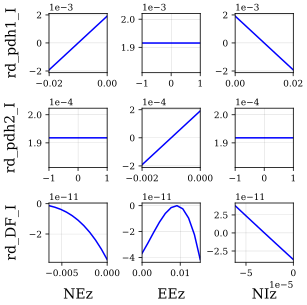

❮CheckLinearitySolution of run locks @ 0x16beb7280 children=0❯

In [8]:
kat.run(CheckLinearity(plot_results=True))

Use **RunLocks** to adjust the lock DOFs until the error signals are within tolerances or until max iterations are reached. This can be done with either the proportional method or the more advanced *newton* method (see **locking documentation** for more information).

In [9]:
kat.run(RunLocks(method="newton",
                                     display_progress=False,
                                     max_iterations=100,
                                     optimize_phase=True,
                                     scale_factor=1))
print()

Use **DragLocks** to gradually introduce a substantial defect in your model, which you might not be able to lock to immediately.

In [10]:
print("Results of dragging locks:")
kat.run(DragLocks(method="newton",
                                      parameters=["NE.Rcx"],
                                      stop_points=[1.8],
                                  relative=True,
                                      max_iterations=100))

Results of dragging locks:


❮RunLocksSolution of run locks @ 0x16c7d1300 children=0❯